In [1]:
%matplotlib inline
import numpy as np
import sklearn.decomposition
import sklearn.feature_extraction
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import bottleneck as bn
import itertools
from sklearn.cross_validation import KFold
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

###Multi-Purpose Functions for Evaluating Models

In [2]:
# computes % accuracy rate of predictions, given a vector of predicted categories and a vector of actual categories
def accuracy(predicted,actual):
    # boolean array of Trues for correct predictions and Falses for incorrect predictions
    correct = map(lambda (c1,c2) : c1==c2, zip(predicted,actual))
    return float(sum(correct)) / len(correct)

We refer to a pair of documents as a true positive ($tp$) if the two documents end up in the same cluster correctly, a true negative ($tn$) if the documents end up in different clusters correctly, a false positive ($fp$) if the documents are placed in the same cluster but should have been in different clusters, and a false negative ($fn$) if the documents are placed in different clusters but should have been in the same cluster.

The Rand Index (measuring the similarity between the NMF clustering and the SCDB categories) is defined as $\frac{tp+tn}{tp+tn+fp+fn}$. This is a useful measure of the quality of an unsupervised algorithm like NMF or k-means; accuracy is harder to interpret exactly because unsupervised algorithm does not use the training set categories to generate clusters.

In [3]:
# computes Rand Index, given a vector of predicted categories and a vector of actual categories
def rand_index(predicted,actual):
    # use itertools to create pairs of documents, using the NMF clusters and SCDB categories
    cluster_pairs_pred = itertools.product(predicted,predicted)
    cluster_pairs_actual = itertools.product(actual,actual)
    # loop through all document pairs to compute tp, tn, fp, and fn
    (tp,tn,fp,fn) = 0, 0, 0, 0
    for pair1,pair2 in zip(cluster_pairs_pred, cluster_pairs_actual):
        if (pair1[0]==pair1[1]):
            if (pair2[0]==pair2[1]):
                tp += 1
            else:
                fp += 1
        else:
            if (pair2[0]==pair2[1]):
                fn += 1
            else:
                tn += 1
    
    # compute and output Rand Index using formula from above
    rand_index_train = float(tp+tn)/(tp+tn+fp+fn)
    return rand_index_train

###Fitting Model with Training Data

In [4]:
%%time
# read in training data from csv
noun_train_mat = np.loadtxt("noun_train_mat.csv", delimiter = ",")
# use TF-IDF to scale each document's vector to have norm 1 and place a lower weight on very common words
tf_idf_fit = sklearn.feature_extraction.text.TfidfTransformer().fit(noun_train_mat)
noun_train_mat = tf_idf_fit.transform(noun_train_mat).toarray()

Wall time: 32 s


In [5]:
%%time
# compute NMF fit
NMF_fit = sklearn.decomposition.NMF(n_components=14, init='nndsvda').fit(noun_train_mat)
H = NMF_fit.components_
W = NMF_fit.transform(noun_train_mat)
# contains a tuple (i,j) if document i is in cluster j, for each document
clusters = map(np.argmax, W)
# list of the documents in each cluster
cluster_lists = [[i for i,j in enumerate(clusters) if j==cluster] for cluster in range(14)]

Wall time: 1min 3s


C:\Users\Madhu\Anaconda\lib\site-packages\sklearn\decomposition\nmf.py:532: UserWarning: Iteration limit reached during fit. Solving for W exactly.
  warnings.warn("Iteration limit reached during fit. Solving for W exactly.")


In [6]:
# classify each document into the category that fits it best
print 'Number of documents per category:', [sum([x==i for x in clusters]) for i in range(14)]

Number of documents per category: [121, 83, 72, 35, 118, 61, 93, 25, 38, 78, 76, 72, 52, 163]


###Key Words for Each Cluster

In [7]:
# load vocab from csv
noun_vocab = np.loadtxt("noun_vocab.csv", delimiter=",", dtype="str")
noun_vocab = [(int(i),j) for i,j in noun_vocab]
id2noun = dict(noun_vocab)

In [8]:
# find and output the 5 most important words for each category
num_best = 5
best_indices = map(lambda v : list(bn.argpartsort(-v,num_best)[0:num_best]), H)
best_words = [[id2noun[i] for i in lst] for lst in best_indices]
best_words

[['claim', 'appeal', 'district', 'court', 'jurisdiction'],
 ['labor', 'union', 'employee', 'board', 'employer'],
 ['tax', 'property', 'income', 'revenue', 'state'],
 ['student', 'board', 'school', 'plan', 'education'],
 ['plan', 'benefit', 'security', 'act', 'employee'],
 ['land', 'water', 'act', 'tribe', 'reservation'],
 ['trial', 'court', 'counsel', 'petitioner', 'state'],
 ['decree', 'master', 'orig ', 'u s ', 'entry'],
 ['alien', 'immigration', 'attorney', 'deportation', 'general'],
 ['gas', 'commission', 'commerce', 'carrier', 'price'],
 ['jury', 'trial', 'evidence', 'verdict', 'petitioner'],
 ['conviction', 'sentence', 'punishment', 'offense', 'crime'],
 ['search', 'warrant', 'officer', 'police', 'respondent'],
 ['state', 'opinion', 'amendment', 'law', 'post']]

In [9]:
# can probably ignore this stuff -- it's a different way to figure out the best words in each category, but it's not working
# and produces nonsense
width = len(M[0])
best_words = np.zeros(14)
for i in range(14):
    # arbitrary high initial value
    w = np.ones(width) * 5000
    #w_val = np.ones(width)
    for j in range(width):
        for k in range(14):
            if i <> k and H[k][j] > 0:
                if w[j] >= float(H[i][j])/H[k][j]:
                    w[j] = float(H[i][j])/H[k][j]
    best_words[i] = np.argmax(w)
print map(lambda x : id2noun[int(x)], best_words)

['narcotic', 'fdca', 'middleman', 'narcotic', 'city the', 'middleman', 'city the', 'middleman', 'fdca', 'narcotic', 'city the', 'fdca', 'city the', 'city the']


###Comparing with Supreme Court Database's Topic Areas

In [10]:
# read in SC Database's issue areas from csv
train_issue_areas = np.loadtxt("train_issue_areas.csv", delimiter = ",", dtype="int")
# zero-index the array
train_issue_areas = train_issue_areas - 1
print 'Number of documents per category:', [sum([x==i for x in train_issue_areas]) for i in range(14)]

# convert the nx1 issue areas vector into a nx14 matrix of dummies, in case that's ever useful
train_issue_areas_dummy = np.array(map(lambda area : np.eye(1,14,area)[0], train_issue_areas))

Number of documents per category: [238, 186, 84, 43, 10, 9, 56, 234, 126, 57, 10, 30, 4, 0]


In [22]:
topic_areas = ['Criminal Procedure', 'Civil Rights', 'First Amendment', 'Due Process', 'Privacy', 'Attorneys', 'Unions',
               'Economic Activity', 'Judicial Power', 'Federalism', 'Interstate Relations', 'Federal Taxation', 'Miscellaneous',
               'Private Action']

####Assignment method 1: use the cluster assignments computed above to find the best SCDB category match

In [14]:
# create a 14x14 matrix (where each row is an NMF cluster and each column is an SCDB cluster) measuring the degree of
# related-ness between each cluster pair
compare_mat = map(lambda r : map(int, r), np.zeros((14,14)))
# first, assign the (i,j) element in the matrix to the number of cases in NMF cluster i and SCDB cluster j, for each (i,j)
for i,j in zip(clusters, train_issue_areas):
    compare_mat[i][j] += 1
# normalize each row to have a sum of 1
compare_mat = map(lambda row : map(float,row) / sum(row), np.array(compare_mat))

# assign each NMF cluster to a (not necessarily unique) SCDB cluster by picking the highest element of each row of compare_mat
assignments = map(np.argmax, compare_mat)
print assignments
# this would be the equivalent way of assigning each SCDB cluster to an NMF cluster; this is printed here but not used anywhere
print map(np.argmax, np.array(compare_mat).T)

[8, 6, 7, 1, 7, 7, 0, 10, 1, 7, 0, 0, 0, 2]
[12, 8, 3, 5, 12, 0, 1, 9, 0, 7, 7, 2, 5, 0]


####Assignment method 2: use the rows of the W matrix (from NMF) to find the best SCDB category match for each cluster

In [12]:
# Difference compared to above: Instead of just thinking of each case as getting assigned to a single cluster (as we did above),
# we can think of each case as having a coefficient for each cluster (from the W matrix), and increment entries of compare_mat
# using those coefficients instead of just incrementing by 1.

# create a 14x14 matrix (where each row is an SCDB cluster and each column is an NMF cluster) measuring the degree of
# related-ness between each cluster pair
compare_mat = np.zeros((14,14))
for i,j in zip(W, train_issue_areas):
    # increment the jth row of compare_mat by the entire row of W corresponding to the current case
    compare_mat[j] = compare_mat[j] + i
# transpose that matrix (so that it's in the same format as the matrix in assignment method 1 above)
compare_mat = compare_mat.T

# assign each NMF cluster to a (not necessarily unique) SCDB cluster by picking the highest element of each row of compare_mat
assignments = map(np.argmax, compare_mat)
print assignments

[8, 6, 7, 1, 7, 7, 0, 9, 1, 7, 0, 0, 0, 1]


####Assignment method 3: use Hungarian algorithm (which computes assignments that minimize cost) to assign each NMF cluster to an SCDB cluster (without any collisions)

In [13]:
### NOTE: probably don't run this -- it generates assignments that have very low accuracy
import munkres
m = munkres.Munkres()
assignments = dict(m.compute(-np.array(compare_mat)))
print assignments

{0: 8, 1: 6, 2: 11, 3: 12, 4: 3, 5: 9, 6: 0, 7: 10, 8: 1, 9: 7, 10: 5, 11: 13, 12: 4, 13: 2}


####Assign an SCDB category to each case, using an assignment array created above 

In [15]:
# use the assignments above to convert the clusters into equivalent SCDB categories for each document
new_clusters = map(lambda cluster : assignments[cluster], clusters)
# compute and output accuracy rate
correct = map(lambda (c1,c2) : c1==c2, zip(new_clusters, train_issue_areas))
print 'Accuracy:', float(sum(correct)) / len(correct)

Accuracy: 0.500459981601


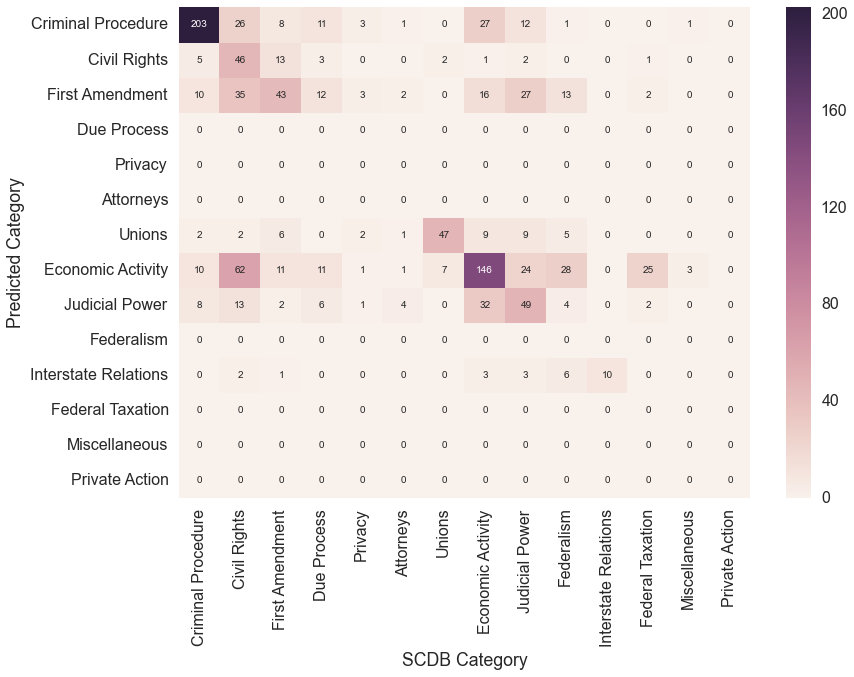

In [66]:
compare_mat_new = map(lambda r : map(int, r), np.zeros((14,14)))
for i,j in zip(new_clusters, train_issue_areas):
    compare_mat_new[i][j] += 1
sns.heatmap(compare_mat_new, annot=True, xticklabels=topic_areas, yticklabels=topic_areas, fmt='d')
sns.axlabel('SCDB Category', 'Predicted Category')

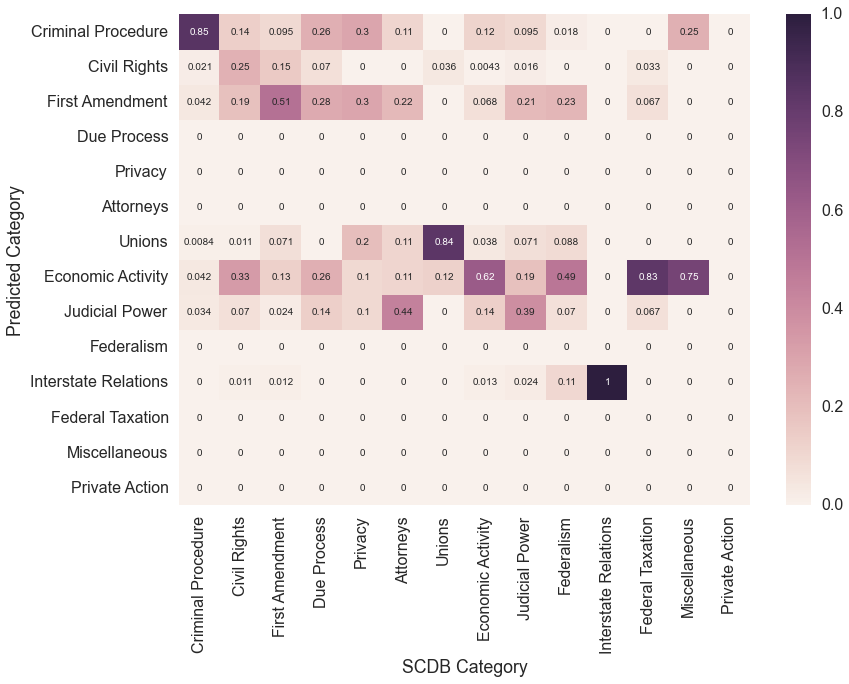

In [67]:
# normalize each column to have a sum of 1
compare_mat_new = np.array(compare_mat_new).T
compare_mat_new = map(lambda row : map(float,row) / sum(row) if sum(row) > 0 else map(float,row), np.array(compare_mat_new))
compare_mat_new = np.array(compare_mat_new).T

# produce a heat map in which the element in row i and column j represent the proportion of cases from SCDB category j that get
# placed in category i by the clustering algorithm
sns.heatmap(compare_mat_new, annot=True, xticklabels=topic_areas, yticklabels=topic_areas)
sns.axlabel('SCDB Category', 'Predicted Category')

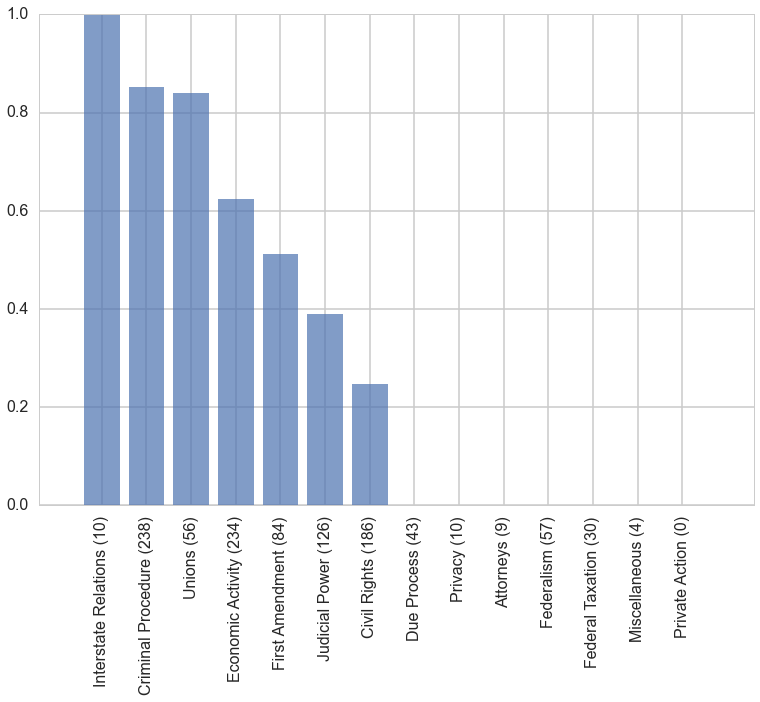

In [118]:
ordered = zip(topic_areas, [sum([x==i for x in train_issue_areas]) for i in range(14)], np.diag(compare_mat_new), range(14))
ordered.sort(key = lambda (topic,num,acc,ind) : -acc)
ordered_topics = list(zip(*ordered)[0])
counts = list(zip(*ordered)[1])
topic_accuracies = list(zip(*ordered)[2])
order = list(zip(*ordered)[3])

#topic_accuracies = [compare_mat_new[order[i]][order[i]] for i in range(14)]

fig, ax = plt.subplots()
ax.bar(np.arange(14)+1, topic_accuracies, alpha=0.7, linewidth=0)

ax.set_xticks(np.arange(14)+1.4)
ax.set_xticklabels(map(lambda (count,topic) : "%s (%s)" % (topic,count), zip(counts,ordered_topics)), rotation='vertical')
print

###Use Rand Index to Compute Accuracy on Training Data

We refer to a pair of documents as a true positive ($tp$) if the two documents end up in the same cluster correctly, a true negative ($tn$) if the documents end up in different clusters correctly, a false positive ($fp$) if the documents are placed in the same cluster but should have been in different clusters, and a false negative ($fn$) if the documents are placed in different clusters but should have been in the same cluster.

The Rand Index (measuring the similarity between the NMF clustering and the SCDB categories) is defined as $\frac{tp+tn}{tp+tn+fp+fn}$.

In [30]:
%%time
if 'cluster_pairs_model' in globals():
    del cluster_pairs_model
if 'cluster_pairs_actual' in globals():
    del cluster_pairs_actual

# use itertools to create pairs of documents, using the NMF clusters and SCDB categories
cluster_pairs_model = itertools.product(new_clusters, new_clusters)
cluster_pairs_actual = itertools.product(train_issue_areas, train_issue_areas)
# loop through all document pairs to compute tp, tn, fp, and fn
(tp,tn,fp,fn) = 0, 0, 0, 0
for pair1,pair2 in zip(cluster_pairs_model, cluster_pairs_actual):
    if (pair1[0]==pair1[1]):
        if (pair2[0]==pair2[1]):
            tp += 1
        else:
            fp += 1
    else:
        if (pair2[0]==pair2[1]):
            fn += 1
        else:
            tn += 1

# output tp, tn, fp, and fn
print tp,tn,fp,fn
# compute and output Rand Index using formula from above
rand_index_train = float(tp+tn)/(tp+tn+fp+fn)
print rand_index_train

83659 838726 164484 94700
0.780644211214
Wall time: 1.64 s


###Cross-Validation

In [31]:
def cv_results_unsupervised(predict, x, y, score_func, nfolds=5):
    results = []
    for train, test in KFold(len(y), nfolds):
        pred = predict(x[train],y[train],x[test])#clf.fit(x[train]).transform(x[test])
        results += [score_func(pred, y[test])] # evaluate score function on held-out data
    return results

In [32]:
# Fits an NMF model with n_components clusters on the data in x_train and y_train, and use that to predict clusters for x_test.
# (Since NMF is unsupervised, the data in y_train is only used to create a mapping from NMF clusters to SCDB clusters, not to
# actually fit the model.)
def fit_transform(x_train, y_train, x_test, n_components):
    # compute an NMF fit on x_train, and produce
    fit = sklearn.decomposition.NMF(n_components=n_components, init='nndsvda').fit(x_train)
    W_train = fit.transform(x_train)
    clusters_train = map(np.argmax, W_train)
    
    # create a 14x14 matrix (where each row is an NMF cluster and each column is an SCDB cluster) measuring the degree of
    # related-ness between each cluster pair
    compare_mat = map(lambda r : map(int, r), np.zeros((n_components,14)))
    # first, assign the (i,j) element in the matrix to the number of cases in NMF cluster i and SCDB cluster j, for each (i,j)
    for i,j in zip(clusters_train, y_train):
        compare_mat[i][j] += 1
    assignments = map(np.argmax, compare_mat)
    
    W_test = fit.transform(x_test)
    clusters_test = map(np.argmax, W_test)
    # use the assignments above to convert the clusters into equivalent SCDB categories for each document
    new_clusters = map(lambda cluster : assignments[cluster], clusters_test)
    return new_clusters

In [44]:
%%time
num_clusters_lst = [5, 10, 15, 20, 25, 30]

results = dict()
for k in num_clusters_lst:
    print 'Testing with %d clusters' % k
    results[k] = cv_results_unsupervised(lambda x,y,z : fit_transform(x,y,z,k), noun_train_mat, train_issue_areas,
                                         lambda pred,act : (accuracy(pred,act), rand_index(pred,act)), nfolds=5)

Testing with 5 clusters
Testing with 10 clusters
Testing with 15 clusters
Testing with 20 clusters
Testing with 25 clusters
Testing with 30 clusters


In [130]:
results_accuracies = dict()
results_rand_ind = dict()
for k in results.keys():
    accuracy_k, rand_index_k = zip(*results[k])
    results_accuracies[k] = np.mean(accuracy_k)
    results_rand_ind[k] = np.mean(rand_index_k)
print results_accuracies
print results_rand_ind

{5: 0.42612612612612616, 10: 0.463963963963964, 15: 0.49279279279279276, 20: 0.51891891891891895, 25: 0.51081081081081092, 30: 0.5}
{5: 0.68445743040337637, 10: 0.7381624868111355, 15: 0.7727944160376593, 20: 0.78395422449476515, 25: 0.78098368638909177, 30: 0.77091145199253297}


##Choose Best Model and Run on Test Data

###Choose Optimal Number of Clusters and Categorize Test Data

####Option 1: Choose optimal n_clusters using average accuracy rate

In [127]:
n_clusters = results_accuracies.keys()[np.argmax(results_accuracies.values())]
n_clusters

20

####Option 2: Choose optimal n_clusters using average Rand Index

In [128]:
n_clusters = results_rand_ind.keys()[np.argmax(results_rand_ind.values())]
n_clusters

20

###Fit Model with Optimal Parameter and Apply to Test Data

In [34]:
%%time
# read in test data from csv
noun_test_mat = np.loadtxt("noun_test_mat.csv", delimiter = ",")
# use TF-IDF fit from training data to scale each document's vector to have norm 1 and place a lower weight on very common words
noun_test_mat = tf_idf_fit.transform(noun_test_mat).toarray()

Wall time: 20.4 s


In [35]:
%%time
clusters_test = fit_transform(noun_train_mat, train_issue_areas, noun_test_mat, n_clusters)
cluster_lists_test = [[i for i,j in enumerate(clusters_test) if j==cluster] for cluster in range(14)]

Wall time: 45 s


###Evaluate Test Data Results Using SC Database Categories

In [36]:
# read in SC Database's issue areas from csv
test_issue_areas = np.loadtxt("test_issue_areas.csv", delimiter = ",", dtype="int")
# zero-index the array
test_issue_areas = test_issue_areas - 1
print 'Number of documents per category:', [sum([x==i for x in test_issue_areas]) for i in range(14)]

Number of documents per category: [104, 97, 38, 15, 3, 6, 26, 104, 68, 24, 5, 17, 1, 0]


In [37]:
print 'Accuracy:', accuracy(clusters_test, test_issue_areas)
print 'Rand Index:', rand_index(clusters_test, test_issue_areas)

Accuracy: 0.488188976378
Rand Index: 0.770467790936


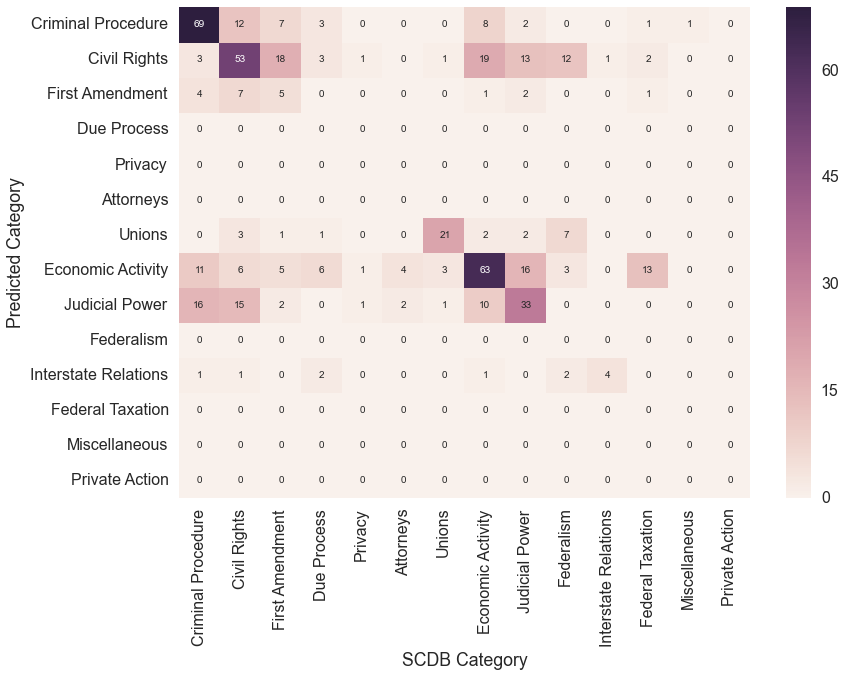

In [48]:
compare_mat_test = map(lambda r : map(int, r), np.zeros((14,14)))
for i,j in zip(clusters_test, test_issue_areas):
    compare_mat_test[i][j] += 1

sns.heatmap(compare_mat_test, annot=True, xticklabels=topic_areas, yticklabels=topic_areas, fmt='d')
sns.axlabel('SCDB Category', 'Predicted Category')

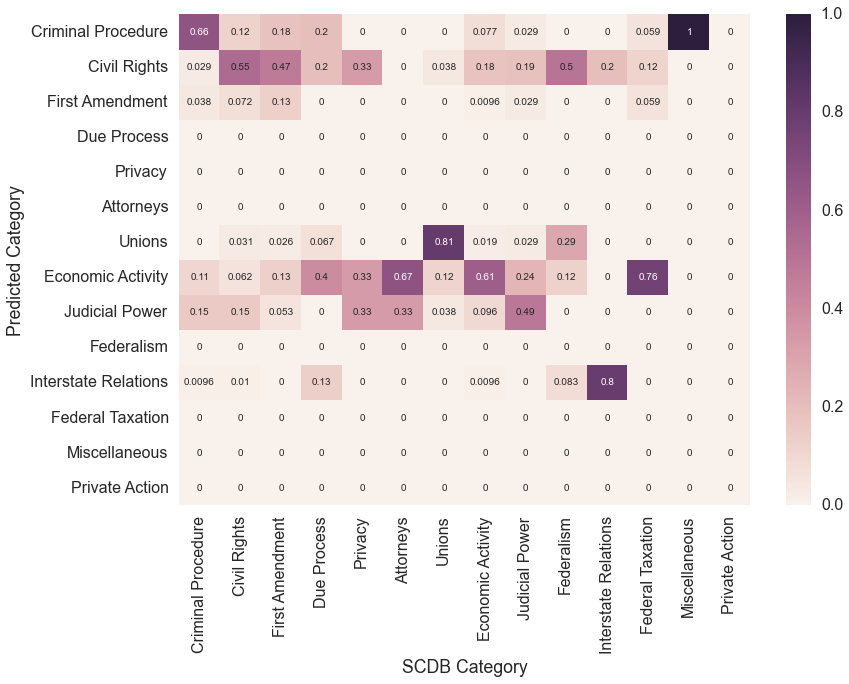

In [41]:
# normalize each column to have a sum of 1
compare_mat_test = np.array(compare_mat_test).T
compare_mat_test = map(lambda row : map(float,row) / sum(row) if sum(row) > 0 else map(float,row), np.array(compare_mat_test))
compare_mat_test = np.array(compare_mat_test).T

# produce a heat map in which the element in row i and column j represent the proportion of cases in the testing set from SCDB
# category j that get placed in category i by the clustering algorithm (trained on the training data with the optimal parameter)
sns.heatmap(compare_mat_test, annot=True, xticklabels=topic_areas, yticklabels=topic_areas)
sns.axlabel('SCDB Category', 'Predicted Category')

In [6]:
# this all-in-one function takes 3 inputs: (1) a list of csv's to retrieve a matrix of 
def evaluate(x_files, y_data, n_clusters):
    # read in text data
    x_data = map(lambda x_file : np.loadtxt(x_file, delimiter=','), x_files)
    x_data = reduce(lambda x1,x2 : np.concatenate((x1,x2),1), x_data)
    # read in issue areas
    #y_data = np.loadtxt(y_file, delimiter = ',', dtype='int')
    # zero-index the array
    #y_data = y_data - 1
    
    # use TF-IDF to scale each document's vector to have norm 1 and place a lower weight on very common words
    tf_idf_fit = sklearn.feature_extraction.text.TfidfTransformer().fit(x_data)
    x_data = tf_idf_fit.transform(x_data).toarray()
    
    # compute NMF fit
    NMF_fit = sklearn.decomposition.NMF(n_components=n_clusters, init='nndsvda').fit(x_data)
    H = NMF_fit.components_
    W = NMF_fit.transform(x_data)
    # contains a tuple (i,j) if document i is in cluster j, for each document
    clusters = map(np.argmax, W)
    
    # create a 14x14 matrix (where each row is an NMF cluster and each column is an SCDB cluster) measuring the degree of
    # related-ness between each cluster pair
    compare_mat = map(lambda r : map(int, r), np.zeros((n_clusters,14)))
    # first, assign the (i,j) element in the matrix to the number of cases in NMF cluster i and SCDB cluster j, for each (i,j)
    for i,j in zip(clusters, y_data):
        compare_mat[i][j] += 1
    # normalize each row to have a sum of 1
    compare_mat = map(lambda row : map(float,row) / sum(row) if sum(row) > 0 else map(float,row), np.array(compare_mat))

    # assign each NMF cluster to a SCDB cluster by picking the highest element of each row of compare_mat
    assignments = map(np.argmax, compare_mat)
    
    # use the assignments above to convert the clusters into equivalent SCDB categories for each document
    new_clusters = map(lambda cluster : assignments[cluster], clusters)
    
    return (accuracy(new_clusters, y_data), rand_index(new_clusters, y_data))

In [9]:
%%time
evaluate(['noun_train_mat.csv','verb_train_mat.csv','adj_train_mat.csv','for_train_mat.csv','prec_train_mat.csv'],
         train_issue_areas, n_clusters=20)

Wall time: 2min 4s


(0.49954001839926404, 0.7721910442809519)